In [1]:
from pathlib import Path

### Some helper functions

In [2]:
import pathlib
from pathlib import Path
import xarray as xr
import pandas as pd


def get_data_from_sample(path: pathlib.Path, drop_duplicate_indices=False):
    """
    Given a path, should return a pandas object that contains all the data in the path.

    drop_duplicate_indices: Bool, defaulf False
    If true, duplicated indices will be dropped, keeping the first value
    """

    files = path.glob('*.txt')

    data = []
    for file in files:
        data.append(get_data_from_txt_file(file))

    data = pd.concat(data, axis='rows')
    if drop_duplicate_indices:
        data = data[~data.index.duplicated(keep='first')]

    return data


def get_data_from_txt_file(p: pathlib.PosixPath, sample_in_index=False):
    """
    Given a filepath (pathlib.PosixPath), returns data, a pandas DataFrame with the data in it.
    
    """
    energy, unit = get_energy(str(p))
    with p.open() as f:
        data = f.readlines()
        
    metadata = data[0].strip().split('\t')
    metadata[0] = metadata[0][1:]

    data = data[1:]
    data = [line.strip() for line in data]
    data = [line.split('\t') for line in data]
    data = [[float(x) for x in line] for line in data]

    data = pd.DataFrame(data, columns=['q', 'I'])
    data['energy'] = energy
    data['sample'] = get_sample_name_from_file_name(p)
    data = data.where(data['I'] > 0).dropna()
    if sample_in_index:
        idx = ['sample', 'energy', 'q']
    else:
        idx = ['energy', 'q']
    data = data.set_index(idx)

    return data


def get_energy(filename: str, key: str = 'keV'):
    """
    Reads the energy from the filename. Currently, requires that the key 'keV' be present.
    Returns: the energy (float) and the unit (str).

    Currently, will probably struggle if the key is not keV.
    """
    f = filename.split(key)
    g = f[0].split('_')[-1]
    g = float(g)
    if key == 'keV':
        unit = key
    return g, unit


def get_sample_name_from_file_name(p: Path):
    """
    Given a path, return the sample.
    """
    fn = str(p.name)
    name = fn.split('/')[-1]
    name = name.split('pos')[0]
    return name

import xarray as xr
import xarray
import numpy as np

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib import cm
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# from ib_mpl_stylesheet.ib_mpl_stylesheet import ib_mpl_style
# plt.style.use(ib_mpl_style)


def plot_sample_from_da(da:xarray.DataArray, fig=None, ax=None, gs=None, kedge=None, colormap='coolwarm',
                        color_linthresh=None,
                        logx=False, logy=False, save_to_file=False,
                        xlabel = r'$q$ [Å$^{-1}$]', ylabel = r'$I$ [a.u.]'):

    ### Create figure
    if fig is None and ax is None:
        fig = plt.figure(figsize=(8,5))
        gs = GridSpec(1,2, left=0.15, bottom=0.15, right=0.87, top=0.98, width_ratios=[20,1], wspace=0.05)
        ax = fig.add_subplot(gs[0,0])
        cmap_ax = fig.add_subplot(gs[0,1])

    energy_range = (np.min(da.coords['energy'].values), np.max(da.coords['energy'].values))

    # if kedge is None:
    #     middle = np.mean(energy_range[0], energy_range[1])

    ### Generate color list
    norm = matplotlib.colors.Normalize(vmin=energy_range[0], vmax=energy_range[1])
    cmap = cmaps[colormap]
    color_list =  [cmap(norm(E)) for E in da.coords['energy']]


    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for E, c in zip(da.coords['energy'], color_list):
        to_plot = da.sel(energy=E).dropna(dim='q', how='all')
        ax.plot(to_plot.coords['q'], to_plot['I'], color=c)

    plt.colorbar(ScalarMappable(cmap=cmap, norm=norm,
                                # ticks=da.coords['q'],
                                # label='Energy'
                                ), cax=cmap_ax)
    cmap_ax.text(4, 0.5, 'Energy [keV]', rotation=270, transform=cmap_ax.transAxes, ha='center', va='center')
    if logx: ax.set_xscale('log')

    if logy: ax.set_yscale('log')

    if save_to_file is not False: fig.savefig(save_to_file, dpi=300, bbox_inches='tight')

    plt.show()

    return



In [3]:
p = Path('.').resolve()

In [4]:
p.cwd()

PosixPath('/Users/ianbillinge/Documents/yiplab/projects/resonant/2023-11-30-BM-12/313303_Billinge_01')

In [5]:
waxs_path = p / 'reduced_waxs'
saxs_path = p / 'reduced_saxs/'

### Plot waxs

In [ ]:
data = []
for i in waxs_path.iterdir():
    if i.is_dir():
        # print(i)
        try:
            d = get_data_from_sample(i)
            d = d.to_xarray()
            # print(d)
            plot_sample_from_da(d, logx=True, logy=True, save_to_file=i / (i.name + 'plot.pdf'))
    
            data.append(d)
        except ValueError as ve:
            print(ve)



### Plot SAXS

In [7]:
# %matplotlib qt

IB_DIPA_RbBr_org_phase-a_pos1_


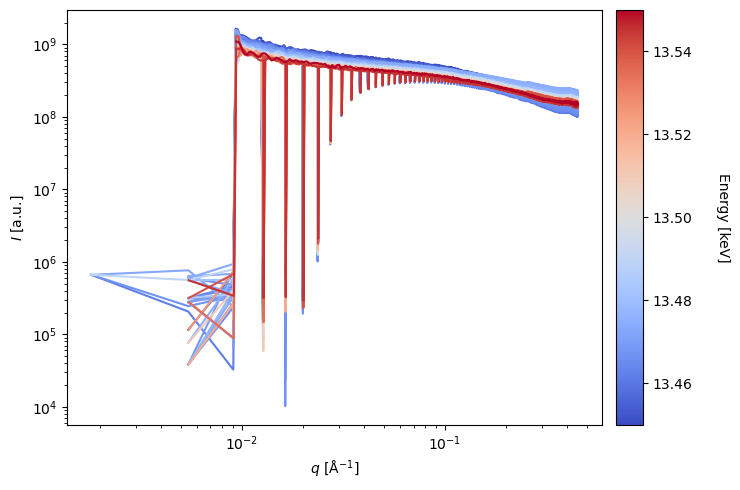

IB_KBr_sol_no_solv-b_pos1_


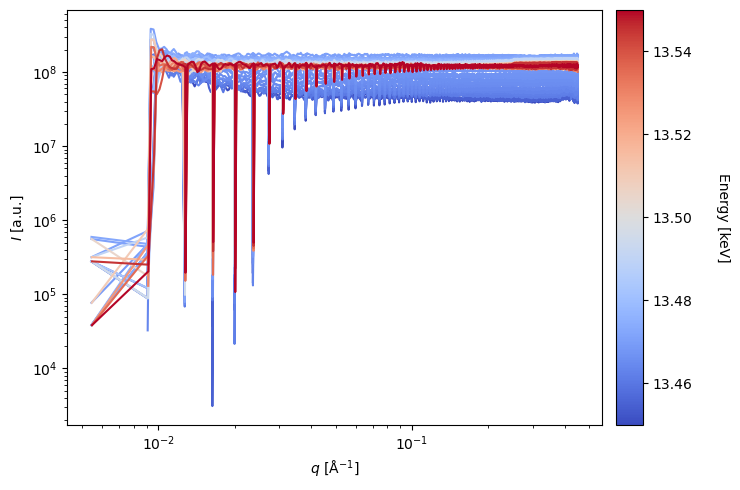

IB_DIPA_RbBr_aq_phase-a_pos1_


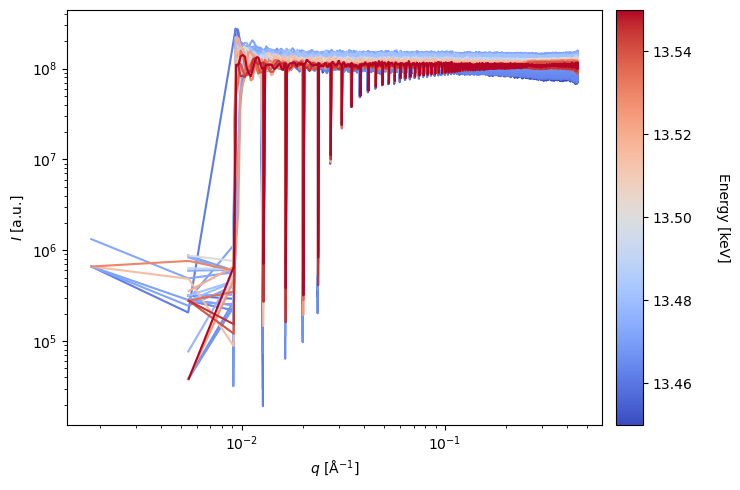

IB_DIPA_LiBr_org_phase-a_pos1_


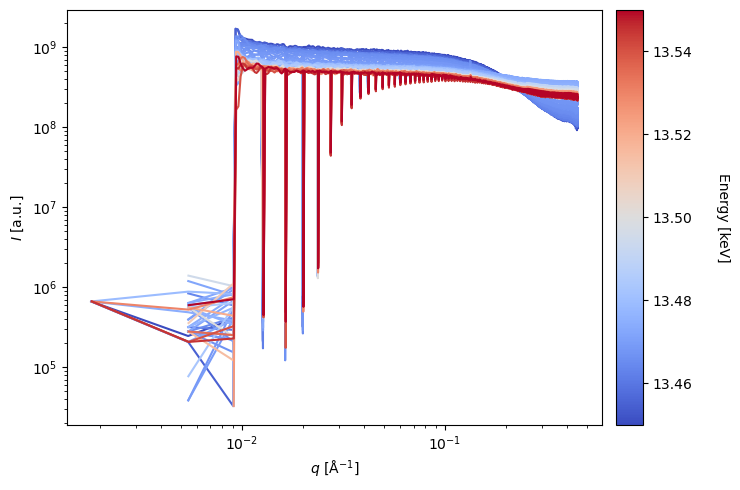

IB_water-a_pos1_


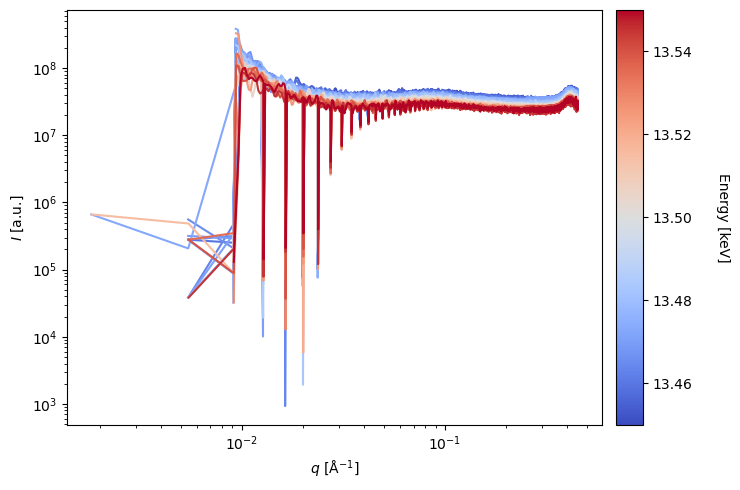

IB_DIPA_NaBr_aq_phase-a_pos1_


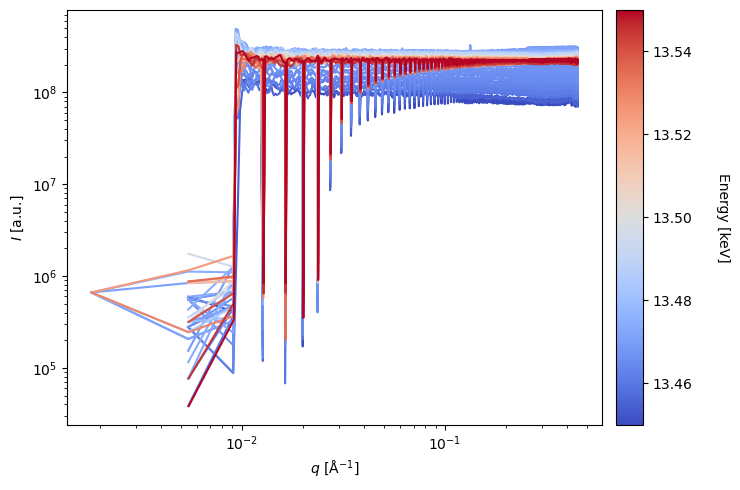

IB_RbBr_sol_no_solv-b_pos1_


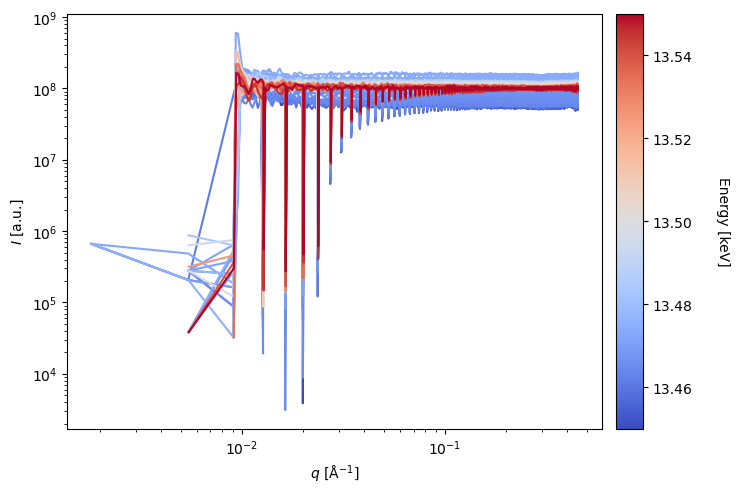

IB_LiBr_sol_no_solv-b_pos1_


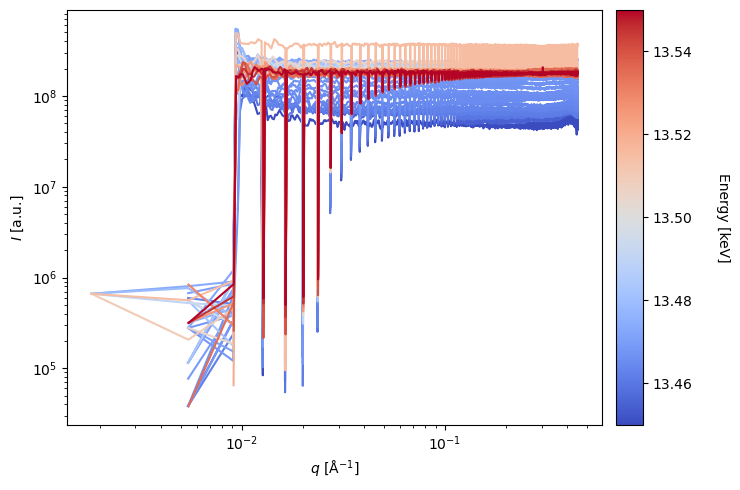

IB_kaptom_pos1_


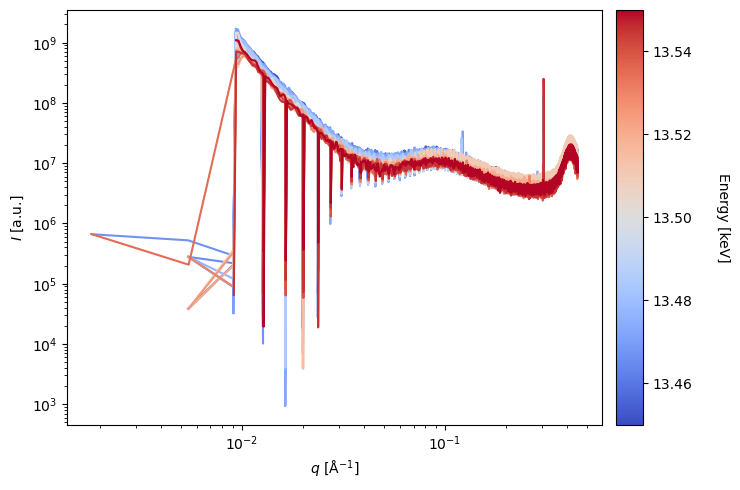

IB_NaBr_sol_no_solv-b_pos1_


In [ ]:
data = []
data2 = []
for i in saxs_path.iterdir():
    if i.is_dir():
        print(i.name)
        try:
            d = get_data_from_sample(i, drop_duplicate_indices=True)
            data2.append(d)

            d = d.to_xarray()            
            d = d.where(d.coords['q'] < 0.45).dropna(dim='energy', how='all')

            plot_sample_from_da(d, logx=True, logy=True, save_to_file=i / (i.name + 'plot.pdf'))
    
            data.append(d)
        except ValueError as ve:
            print(ve)
    

In [ ]:
# data2[0].where(data2[0]['energy'] < 13.47).where(data2[0]['energy'] > 13.46).dropna()
t = data2[0]
print(t.shape)
print(t.index.duplicated())